In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from nettools import readfiles, gridhalos
from pmesh.pm import ParticleMesh
from nbodykit.source.catalog import BigFileCatalog
from nbodykit.lab import BigFileMesh

import sys, os

from time import time
#from itertools import product as iprod

from ruamel.yaml import YAML
yaml=YAML(typ='safe')   # default, if not specfied, is 'rt' (round-trip)
import ruamel
import warnings
warnings.simplefilter('ignore', ruamel.yaml.error.MantissaNoDotYAML1_1Warning)

In [3]:
cfname = 'params400.yml'

In [4]:
with open(cfname, 'r') as ymlfile:
    ddict = yaml.load(ymlfile)

#bs, nc, zz = ddict['bs'], ddict['nc'], ddict['zz']
for i in ['bs', 'nc', 'zz', 'nsteps', 'nfsteps', 'numd', 'fine', 'R1', 'kmin', 'kmax']: 
    locals()[i] = ddict[i]
R2 = R1 * ddict['sfac']

pm = ParticleMesh(BoxSize = bs, Nmesh = [nc, nc, nc], dtype = 'f8')

for key in ddict: print(key, ' = ', ddict[key])

###########

#for seed in ddict['seeds']:
#    pass
seed = 100
proj = '/data2/cosmo4d/'
dpath = proj + 'L%04d_N%04d_S%04d_%02dstep/'%(bs, nc, seed, 5)
dpathf = proj + 'L%04d_N%04d_S%04d_%02dstep/'%(bs, fine*nc, seed, 40)
meshdict, halos = readfiles(pm, dpath, R1, R2, abund=False, quad=False, z=zz, shear=False)
halosf = gridhalos(pm, dpath=dpathf, rank = None, abund=False, sigma=False, seed=seed, pmesh = True, z=zz)

print('Keys in meshdict ',meshdict.keys())
print('Keys in halos ', halos.keys())
print('Length of list halosf ', len(halosf))
print('Keys in halosf[0] ',halosf[0].keys())
print('Keys in halosf[1] ',halosf[1].keys())

bs  =  400
nc  =  128
seed  =  100
nsteps  =  5
zz  =  0.0
nfsteps  =  40
numd  =  0.001
fine  =  4
sigma  =  None
R1  =  3
sfac  =  1.2
ratio  =  1
ratiofine  =  1
ratiolow  =  0
clim  =  0.001
hlim  =  0.001
pftname  =  ['final', 'R1', 'R12']
plocal  =  False
classify  =  True
abund  =  True
mode  =  fine
kmin  =  0.05
kmax  =  0.8
Wts  =  [50, 30, 1]
tseeds  =  [100]
width  =  3
valid  =  0
batch  =  1000
epochs  =  30
tmax  =  30
nreg  =  0.001
drop  =  0.3
lr0  =  0.01
lrmin  =  0.0001
keychange  =  ['hlim', 'clim', 'nreg', 'batch']
changestrain  =  [True, True, False, False]
keyvals  =  [[0.1, 0.01, 0.001], [0.1, 0.01, 0.001], [0.001, 0.1], [400000]]
Read Halo files
BigFileCatalog read
BigFileCatalog read
Not implemented
Keys in meshdict  dict_keys(['final', 'decic', 'R1', 'R2', 'R12', 'hposmesh', 'halomesh', 'hmR1mesh', 'hmR2mesh'])
Keys in halos  dict_keys(['position', 'mass', 'velocity'])
Length of list halosf  2
Keys in halosf[0]  dict_keys(['hposmesh', 'halomesh'])
Keys in h

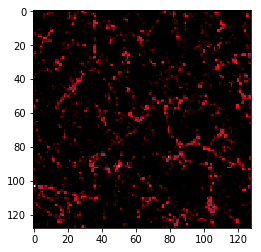

In [5]:
imshow(halosf[0]['halomesh'][0:5].mean(axis=0),cmap='gist_stern')

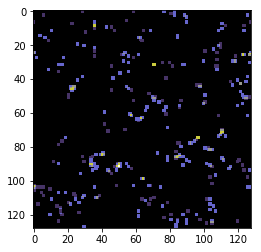

In [6]:
imshow((meshdict['halomesh'][0:5]>0).mean(axis=0),cmap='gist_stern')

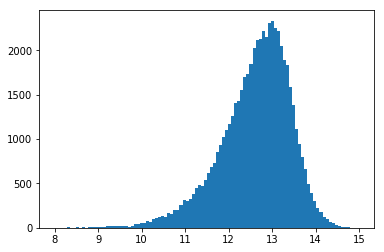

In [7]:
hist(log10(meshdict['halomesh'].flatten()+1), 100, range=[8,15]);

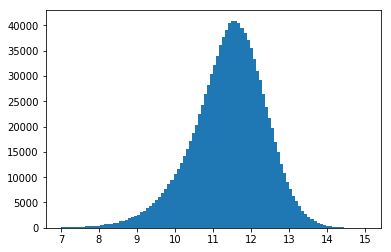

In [8]:
hist(log10(halosf[0]['halomesh'].flatten()+1), 100, range=[7,15]);

In [13]:
num_cubes=5000
box_size = 32
max_offset = 128 - box_size
cube_features = []
cube_target = []

for it in range(num_cubes):
    # Extract random cubes from the sim
    offset_x = round(rand()*max_offset)
    offset_y = round(rand()*max_offset)
    offset_z = round(rand()*max_offset)
    
    cube_features.append( clip(log10(halosf[0]['halomesh'][offset_x:offset_x+box_size,
                                          offset_y:offset_y+box_size,
                                          offset_z:offset_z+box_size] + 0.1),0,None))
    
    cube_target.append(1.0*(meshdict['halomesh'][offset_x:offset_x+box_size,
                                          offset_y:offset_y+box_size,
                                          offset_z:offset_z+box_size] > 1))
    
cube_target = np.stack(cube_target,axis=0).reshape((-1,box_size,box_size,box_size,1))
cube_features = np.stack(cube_features,axis=0).reshape((-1,box_size,box_size,box_size,1))

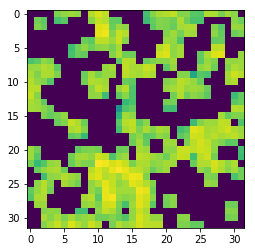

In [14]:
imshow(cube_features[1][0,:,:,0])

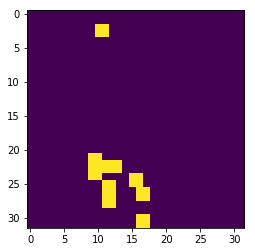

In [15]:
imshow(cube_target[1][0,:,:,0])

In [9]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import add_arg_scope

In [113]:
# Implement a simple masked CNN layer
# Using the shifting idea of the pixelCNN++

@add_arg_scope
def down_right_shifted_conv3d(x, num_filters, filter_size=[2,2,2], stride=[1,1,1], **kwargs):
    x = tf.pad(x, [[0,0], [filter_size[0]-1, 0], [filter_size[1]-1, 0], [filter_size[2]-1, 0], [0,0]])
    return slim.conv3d(x, num_filters, filter_size, stride=stride, padding='valid', **kwargs)

batch_size=32

# Input features, density field
x = tf.placeholder(tf.float32, shape=[batch_size, 32,32,32,1])

# Output features, halos
y = tf.placeholder(tf.float32, shape=[batch_size, 32,32,32,1])
lr = tf.placeholder(tf.float32)

# Apply a masked convolution at the input y to prevent self-connection
# net = tf.concat([slim.conv3d(x, 16, 3, activation_fn=tf.nn.leaky_relu),
#                  down_right_shifted_conv3d(y, 16, activation_fn=tf.nn.leaky_relu)],axis=-1)
net = slim.conv3d(x, 16, 3, activation_fn=tf.nn.leaky_relu)
net = slim.conv3d(net, 64, 3, activation_fn=tf.nn.leaky_relu) #down_right_shifted_conv3d(net, 32, activation_fn=tf.nn.leaky_relu)
net = slim.conv3d(net, 16, 3, activation_fn=tf.nn.leaky_relu)#down_right_shifted_conv3d(net, 1, activation_fn=None)
net = slim.conv3d(net, 1, 3, activation_fn=None)
pred = tf.nn.sigmoid(net)

loss = tf.losses.sigmoid_cross_entropy(y, net)

In [114]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr)

opt_op = optimizer.minimize(loss)

In [115]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [116]:
losses = []

In [121]:
niter= 500

for it in range(niter):
    inds = np.random.choice(5000, batch_size, replace=False)
    _, l = sess.run([opt_op, loss], feed_dict={lr:0.0001, x:cube_features[inds], y:cube_target[inds]})
    if it % 100 == 0:
        print(l)
    losses.append(l)

0.07465708
0.07167466
0.06967065
0.07254337
0.07501091


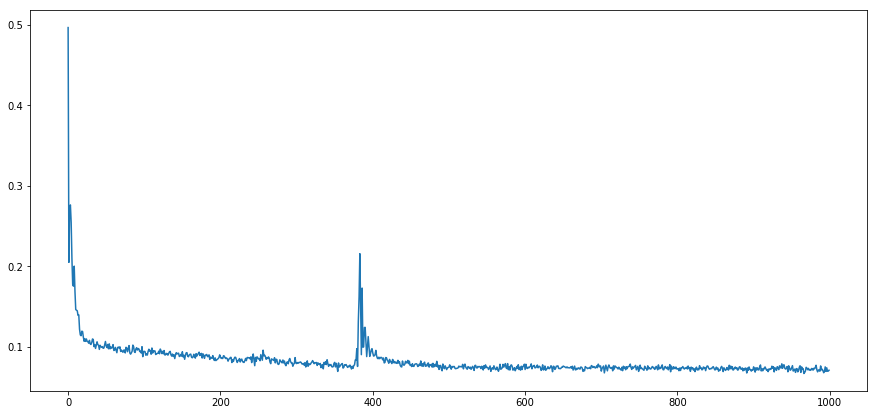

In [122]:
plot(losses)

In [123]:
rec,recp = sess.run([net, pred], feed_dict={x:cube_features[inds], y:cube_target[inds]})

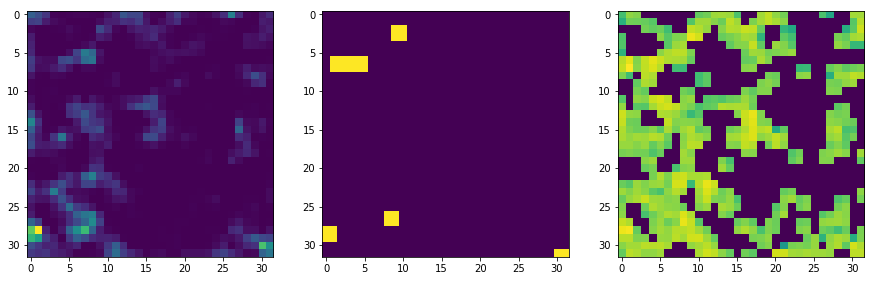

In [124]:
figsize(15,7)
subplot(131)
imshow(recp[3,0,:,:,0]);
subplot(132)
imshow(cube_target[inds][3,0,:,:,0],vmax=1);
subplot(133)
imshow(cube_features[inds][3,0,:,:,0]);

In [89]:
# Try to sample the cube
rec_cube = zeros_like(cube_features[inds])
for i in range(1):
    for j in range(32):
        for k in range(32):
            r = sess.run(pred,feed_dict={x:cube_features[inds], y:rec_cube})
            rec_cube[:,i,j,k,0] = r[:,i,j,k,0] > 0.5

KeyboardInterrupt: 

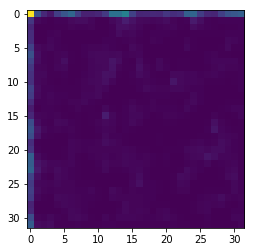

In [90]:
imshow(r[3,0,:,:,0])

In [91]:
rec_cube[3,0,15,15,0] = 1.

In [92]:
r = sess.run(pred,feed_dict={x:cube_features[inds], y:rec_cube})

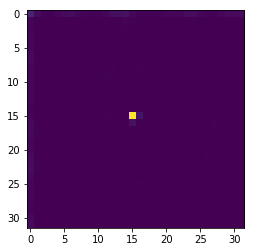

In [93]:
imshow(r[3,0,:,:,0])

In [94]:
r[3,0,15,15,0]

0.93584704